In [1]:
import numpy as np
import cPickle as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo)
    fo.close()
    return dict


def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

batch1 = unpickle('data/cifar-10-batches-py/data_batch_1')
batch2 = unpickle('data/cifar-10-batches-py/data_batch_2')
batch3 = unpickle('data/cifar-10-batches-py/data_batch_3')
batch4 = unpickle('data/cifar-10-batches-py/data_batch_4')
batch5 = unpickle('data/cifar-10-batches-py/data_batch_5')
test_batch = unpickle('data/cifar-10-batches-py/test_batch')

main_dataset = np.vstack([batch1['data'], batch2['data'], batch3['data'], batch4['data'], batch5['data']])
main_labels = np.reshape(np.array(np.hstack([batch1['labels'], batch2['labels'],
                                  batch3['labels'], batch4['labels'], batch5['labels']])), (np.shape(main_dataset)[0],))

test_dataset = test_batch['data']
test_labels = np.reshape(np.array(test_batch['labels']), (np.shape(test_dataset)[0],))

print np.shape(main_dataset)
print np.shape(main_labels)

main_dataset, main_labels = randomize(main_dataset, main_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

cross_valid = 5000

train_dataset = main_dataset[:np.shape(main_dataset)[0] - cross_valid, :]
valid_dataset = main_dataset[np.shape(main_dataset)[0]-cross_valid:, :]

train_labels = main_labels[:len(main_labels)-cross_valid]
valid_labels = main_labels[len(main_labels)-cross_valid:]

print np.unique(valid_labels)
print np.bincount(valid_labels)

print np.unique(train_labels)
print np.bincount(train_labels)

print np.unique(test_labels)
print np.bincount(test_labels)

print "Train Dataset Dimensions:"
print np.shape(train_dataset), np.shape(train_labels)

print "Valid Dataset Dimensions:"
print np.shape(valid_dataset), np.shape(valid_labels)

print "Test Dataset Dimensions:"
print np.shape(test_dataset), np.shape(test_labels)

(50000, 3072)
(50000,)
[0 1 2 3 4 5 6 7 8 9]
[528 504 485 483 500 502 528 523 484 463]
[0 1 2 3 4 5 6 7 8 9]
[4472 4496 4515 4517 4500 4498 4472 4477 4516 4537]
[0 1 2 3 4 5 6 7 8 9]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
Train Dataset Dimensions:
(45000, 3072) (45000,)
Valid Dataset Dimensions:
(5000, 3072) (5000,)
Test Dataset Dimensions:
(10000, 3072) (10000,)


In [2]:
image_size = 32
num_channels = 3
num_labels = 10

def format_data(rgb, width=32, height=32, num_colors=3):
   rgb = rgb.reshape(-1, num_colors, width * height).reshape(-1, num_colors, width, height)
   return rgb.swapaxes(3, 1).swapaxes(1, 2)

def reformat(dataset, labels):
  rgb = dataset.reshape(-1, num_channels, image_size * image_size).reshape(-1, num_channels, image_size, image_size)
  dataset = rgb.swapaxes(3, 1).swapaxes(1, 2)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print "Train Dataset Dimensions:"
print np.shape(train_dataset), np.shape(train_labels)

print "Valid Dataset Dimensions:"
print np.shape(valid_dataset), np.shape(valid_labels)

print "Test Dataset Dimensions:"
print np.shape(test_dataset), np.shape(test_labels)

Train Dataset Dimensions:
(45000, 32, 32, 3) (45000, 10)
Valid Dataset Dimensions:
(5000, 32, 32, 3) (5000, 10)
Test Dataset Dimensions:
(10000, 32, 32, 3) (10000, 10)


[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


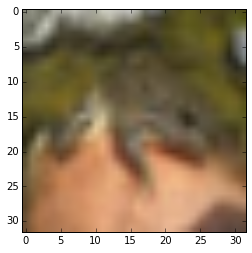

In [5]:
test_img = train_dataset[1001, :, :, :]

plt.imshow(test_img)
print train_labels[1001, :]

In [141]:
def mean_center(dataset):
    return ((dataset - 255.0/2)/255.0).astype(np.float32)

train_dataset = mean_center(train_dataset)
valid_dataset = mean_center(valid_dataset)
test_dataset = mean_center(test_dataset)

In [162]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

image_size = 32
num_labels = 10
num_channels = 3 # grayscale
batch_size = 100
patch_size = 5
depth = 64
layer1 = 384
layer2 = 192

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  hidden_dprob = tf.placeholder('float')
  
  # Variables.
  w1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  b1 = tf.Variable(tf.zeros([depth]))
  w2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
  b2 = tf.Variable(tf.constant(1.0, shape=[depth]))
  w3 = tf.Variable(tf.truncated_normal([image_size / (2 * 2) * image_size / (2 * 2) * depth, layer1], stddev=0.1))
  b3 = tf.Variable(tf.constant(1.0, shape=[layer1]))
  w4 = tf.Variable(tf.truncated_normal([layer1, layer2], stddev=0.1))
  b4 = tf.Variable(tf.constant(1.0, shape=[layer2]))
  w5 = tf.Variable(tf.truncated_normal([layer2, num_labels], stddev=0.1))
  b5 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def train_model(data):
    conv = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b1)
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, w2, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b2)
    pool = tf.nn.max_pool(relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
    shape = pool.get_shape().as_list()
    print shape[0], shape[1], shape[2], shape[3]
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    print reshape.get_shape().as_list()
    hidden = tf.nn.relu(tf.matmul(reshape, w3) + b3)
    hidden_dropout = tf.nn.dropout(hidden, hidden_dprob)
    hidden2 = tf.nn.relu(tf.matmul(hidden_dropout, w4) + b4)
    hidden2_dropout = tf.nn.dropout(hidden2, hidden_dprob)
    return tf.matmul(hidden2_dropout, w5) + b5

  def test_model(data):
    conv = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b1)
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, w2, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b2)
    pool = tf.nn.max_pool(relu, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, w3) + b3)
    hidden2 = tf.nn.relu(tf.matmul(hidden, w4) + b4)
    return tf.matmul(hidden2, w5) + b5
    
  
  # Training computation.
  logits = train_model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  #loss += 0.01 * (tf.nn.l2_loss(w3) + tf.nn.l2_loss(b3) +
  #               tf.nn.l2_loss(w4) + tf.nn.l2_loss(b4))
  
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.05,
                                            global_step * batch_size,
                                            train_labels.shape[0] * 5,
                                            0.95,
                                            staircase=True)
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Add ops to save and restore all the variables.
  saver = tf.train.Saver()

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(test_model(tf_train_dataset))
  valid_prediction = tf.nn.softmax(test_model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(test_model(tf_test_dataset))


num_epochs = 100

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(int(num_epochs * (train_labels.shape[0]/batch_size)) + 1):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, hidden_dprob : 0.7}
    _, l, lr, predictions = session.run([optimizer, loss, learning_rate, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print "------------------------------------------"
      print "Current epoch: ", (float(step) * batch_size) / train_labels.shape[0]
      print "Current learning rate: ", lr
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
    if (step % 1000 == 0):
      # Save the variables to disk.
      save_path = saver.save(session, "./model.ckpt")
      print "Model saved in file: ", save_path

  print "===================================="
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

100 8 8 64
[100, 4096]
Initialized
------------------------------------------
Current epoch:  0.0
Current learning rate:  0.05
Minibatch loss at step 0 : 19.853
Minibatch accuracy: 11.0%
Validation accuracy: 10.0%
Model saved in file:  ./model.ckpt
------------------------------------------
Current epoch:  0.222222222222
Current learning rate:  0.05
Minibatch loss at step 100 : 2.10565
Minibatch accuracy: 29.0%
Validation accuracy: 24.7%
------------------------------------------
Current epoch:  0.444444444444
Current learning rate:  0.05
Minibatch loss at step 200 : 2.00249
Minibatch accuracy: 33.0%
Validation accuracy: 28.1%
------------------------------------------
Current epoch:  0.666666666667
Current learning rate:  0.05
Minibatch loss at step 300 : 1.86668
Minibatch accuracy: 35.0%
Validation accuracy: 35.5%
------------------------------------------
Current epoch:  0.888888888889
Current learning rate:  0.05
Minibatch loss at step 400 : 1.82335
Minibatch accuracy: 33.0%
Valida

KeyboardInterrupt: 